In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import numpy as np
import re
import os
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pylab
import matplotlib as mpl
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

pd.set_option('max_columns', 1000) 
mpl.style.use('ggplot')
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
pylab.rcParams['figure.figsize'] = 12,8

In [2]:
SAVE_PROCESSED_DATA = True

In [3]:
scriptDir = os.getcwd()
relPath = r"../Customer Segmentation/"
sampleFilePath = os.path.join(scriptDir, relPath, 'whole_dataset.csv')
relPathOutput = r"../output/"
outputFolderPath = os.path.join(scriptDir, relPathOutput)

In [4]:
df = pd.read_csv(sampleFilePath, sep=',', header=0, quotechar='"', encoding='latin1')
df = df.drop(['companyid'], axis=1)

# Prepare Data For Consumption

In [5]:
Target = ['ProfitMargin(%)']
Features = ['HashEncode_0', 'HashEncode_1', 'HashEncode_2', 'HashEncode_3', 'HashEncode_4', 'HashEncode_5', 
       'HashEncode_7', 'Round_trip', 'Scaled_gross_log', 'Scaled_Distance_log',
       'Scaled_FlightTime_log', 'Country_France', 'Country_Germany',
       'Country_Italy',  'Country_Other', 'Country_United Kingdom',
       'Country_United States', 'Product_Tour Ops', 'passengersRange_1', 'passengersRange_2',
       'passengersRange_3',  'Class', 'categ_aircraft', 'categ_1', 'categ_3', 'categ_4', 'categ_5']

In [6]:
len(Features)

27

# Ensembling & Stacking models

## base-line classifier

In [72]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
import pydotplus
import matplotlib.cm as cm

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df[Features], df[Target], test_size = 0.33, random_state = 0)
train_data, val_data, train_y, val_y = train_test_split(X_train, y_train, train_size=0.8, random_state=21)

In [9]:
model = DecisionTreeClassifier(criterion='entropy')
model.fit(X_train, y_train)
y_test_hat = model.predict(X_test)   

accuracy = accuracy_score(y_test, y_test_hat)
print('Accuracy_score: %.2f%%' % (accuracy * 100))

Accuracy_score: 71.65%


In [10]:
# dot_data = tree.export_graphviz(model, out_file=None, feature_names=Features, class_names=Target,
#                                 filled=True, rounded=True, special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data)
# graph.write_pdf('airpartner.pdf')

### Feature extraction by using random forest
- split the train dataset into trainset and validation set

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [105]:
np.random.seed(21)

rf_reg = RandomForestClassifier(n_estimators = 750, verbose=1)
rf_reg.fit(train_data, train_y)

combine_lists = lambda item: [item[0], item[1]]

feature_imp = list(map(combine_lists, zip(train_data.columns, rf_reg.feature_importances_)))
feature_imp = pd.DataFrame(
        feature_imp, columns=['Feature', 'Importance']
).sort_values(by='Importance', ascending=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 750 out of 750 | elapsed:    3.9s finished


### All features with filtering importance less than 0.001 include constructed features

In [14]:
feature_imp['Importance'].mean()

0.037037037037037035

In [106]:
feature_imp.head()

,Feature,Importance
8,Scaled_gross_log,0.255480
26,categ_5,0.147040
9,Scaled_Distance_log,0.134369
10,Scaled_FlightTime_log,0.124634
21,Class,0.036893


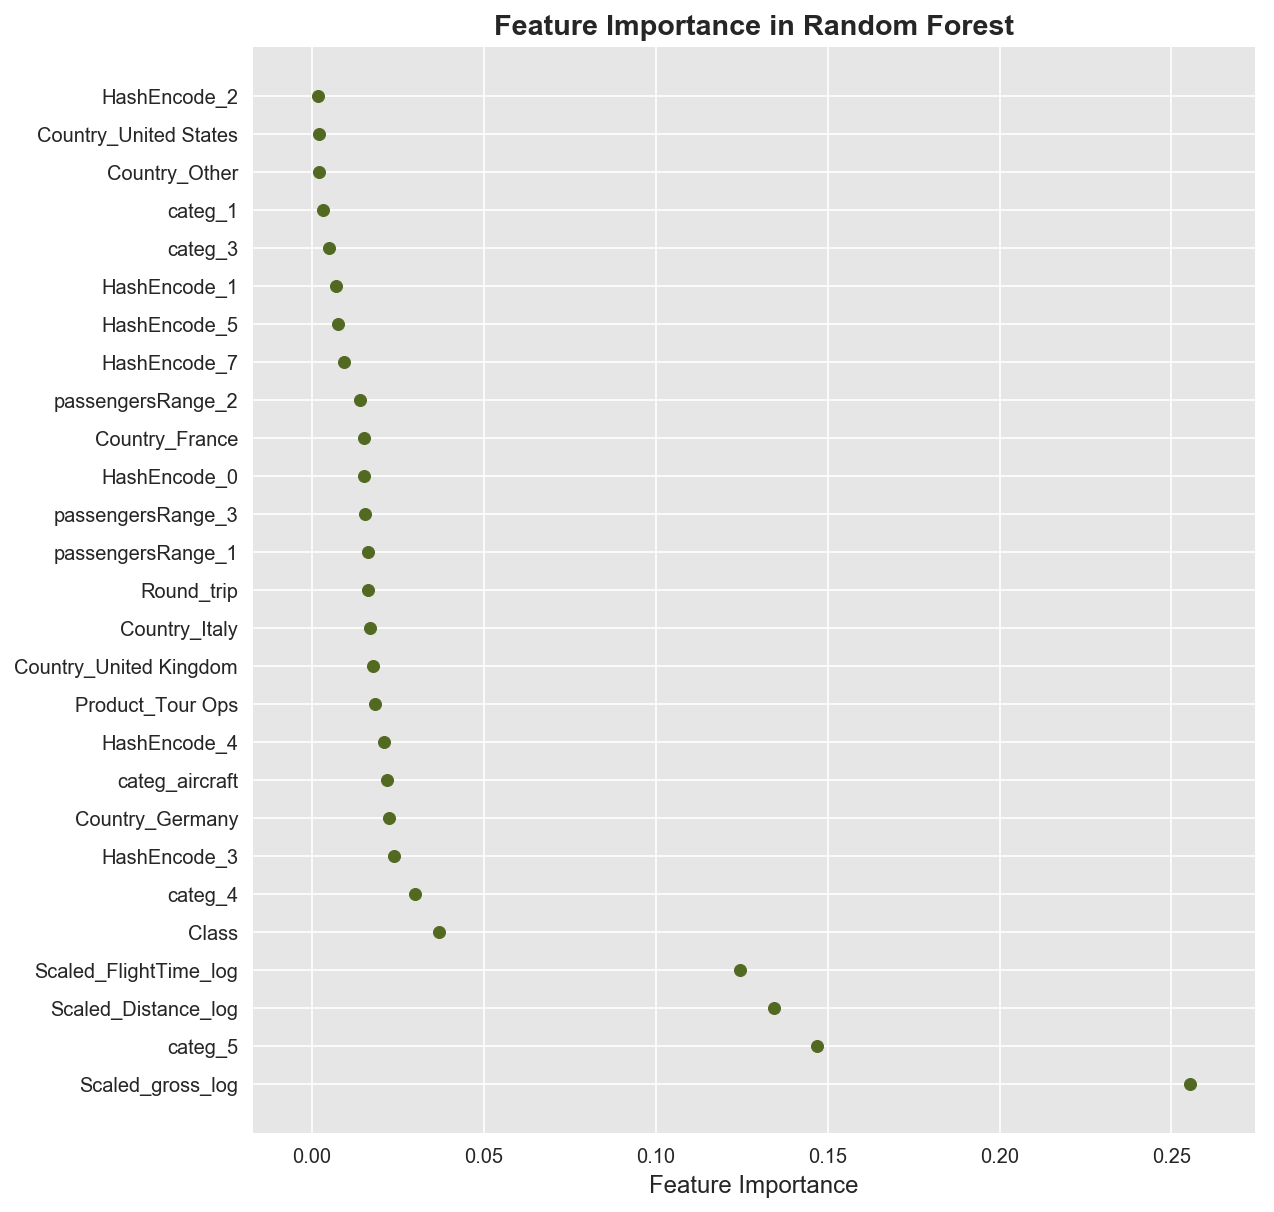

In [107]:
fig = plt.figure(figsize=(9,10))
plt.scatter(x=feature_imp['Importance'], y=feature_imp['Feature'], c='#526922')
plt.title('Feature Importance in Random Forest', fontweight='bold')
plt.xlabel('Feature Importance')
plt.show()

In [15]:
filter_feature = feature_imp[feature_imp['Importance'] > 0.01]['Feature'].tolist()

In [16]:
len(filter_feature)

19

### Visualize the basic prediction

In [17]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [18]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df[filter_feature], df[Target], test_size = 0.33, random_state = 0)

In [20]:
kfold = StratifiedKFold(n_splits=10)

In [21]:
random_state = 2
classifiers = []

classifiers.append(BaggingClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(XGBClassifier())
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())
# classifiers.append(GaussianProcessClassifier())

In [22]:
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))
    
    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["Bagging","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","SVC","XGboost","MultipleLayerPerceptron","KNeighboors",\
"LogisticRegression","LinearDiscriminantAnalysis"]})

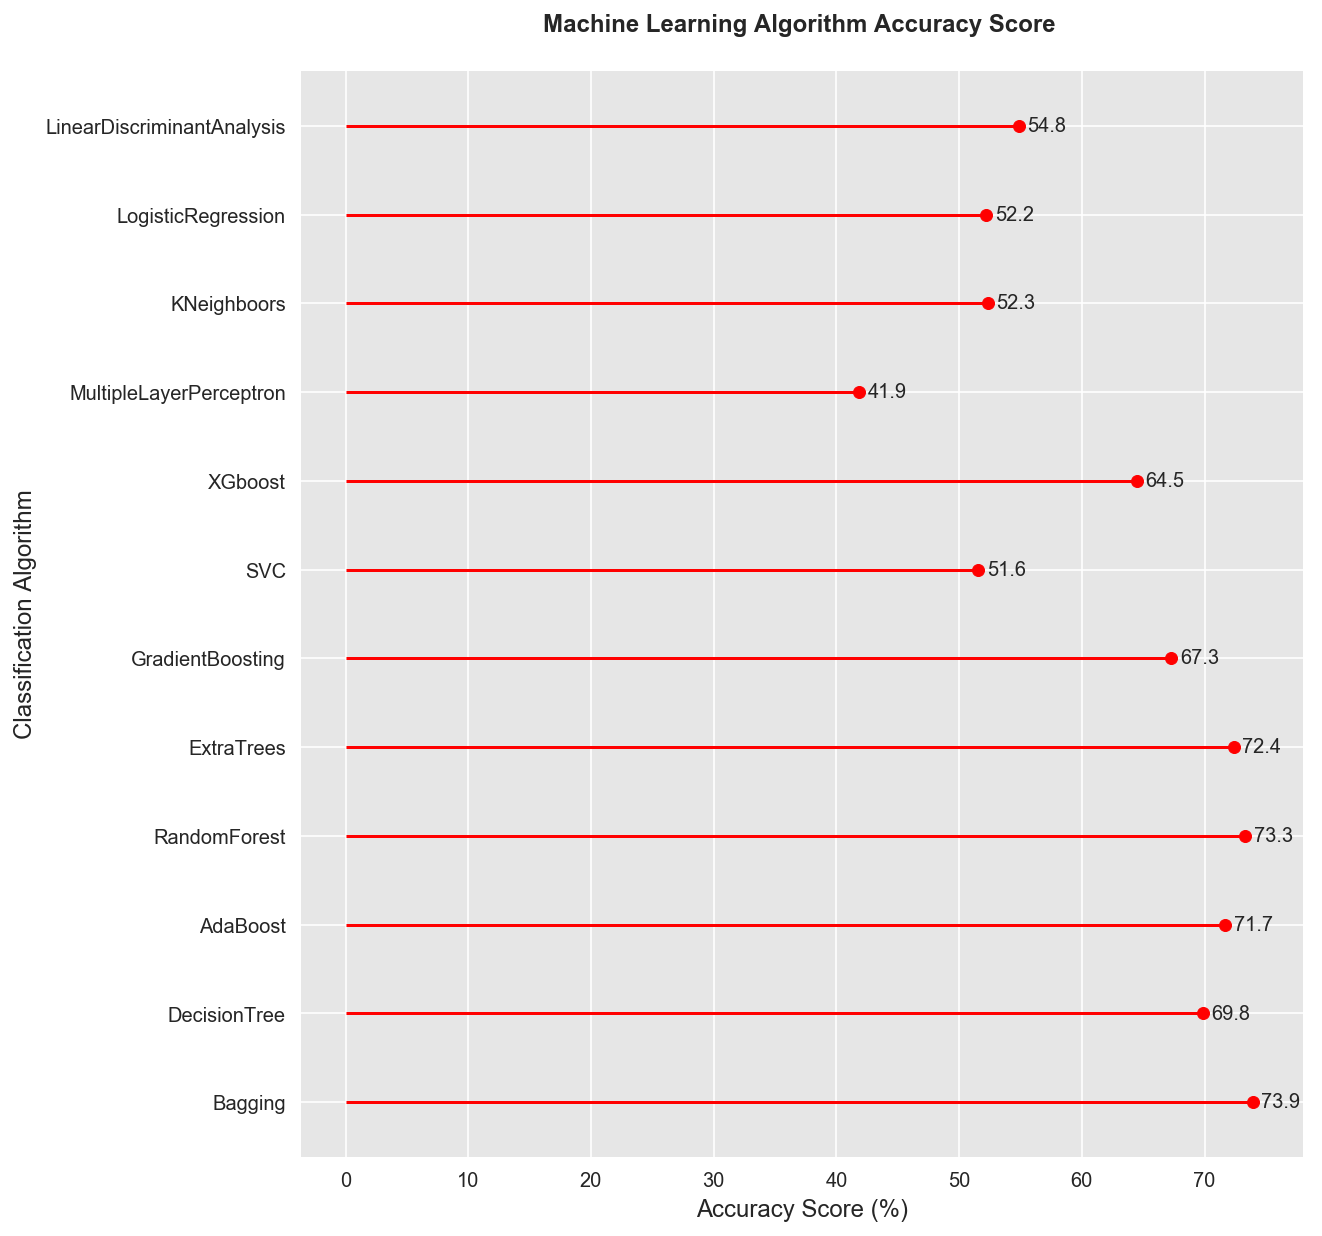

In [99]:
fig, ax = plt.subplots(figsize=(9,10), dpi= 72)

plt.hlines(xmin=0, xmax=cv_res['CrossValMeans'] * 100, y=cv_res['Algorithm'], color='r')
plt.scatter(x=cv_res['CrossValMeans'] * 100, y=cv_res['Algorithm'], color='r')

# fig.scatter(x=df.index, y=df.cty, s=75, color='firebrick', alpha=0.7)
plt.title('Machine Learning Algorithm Accuracy Score \n', fontsize='large', fontweight='bold')
plt.xlabel('Accuracy Score (%)', fontsize='large')
plt.ylabel('Classification Algorithm', fontsize='large')

for row in cv_res.itertuples():
    plt.text(row.CrossValMeans*100+2.3, row.Index, s=round(row.CrossValMeans*100, 1),  horizontalalignment= 'center', verticalalignment='center')
plt.show()

## Other classifiers

### Hyperparameter tunning for best models
- Bagging, AdaBoost, RandomForest and ExtraTrees perfrom the 70 plus score in the experiment, so that I choose those classifiers for the ensemble modeling.

In [24]:
from sklearn.metrics import mean_squared_error

In [25]:
evaluation = pd.DataFrame({'Model': [],
                           'Parameters':[],
                           'Root Mean Squared Error (RMSE)':[],
                           'R-squared (training)':[],
                           'Adjusted R-squared (training)':[],
                           'R-squared (test)':[],
                           'Adjusted R-squared (test)':[],
                           '10-Fold Cross Validation':[]})

In [26]:
def adjustedR2(r2,n,k):
    return r2-(k-1)/(n-k)*(1-r2)

In [27]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#### AdaBoostClassifier hyperparameter tunning

In [28]:
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[3,4],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.15, 0.2, 0.3,1.5]}

gs_adaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gs_adaDTC.fit(X_train, y_train)

ada_best = gs_adaDTC.best_estimator_
pred = gs_adaDTC.predict(X_test)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.4s
[Parallel(n_jobs=4)]: Done 672 tasks      | elapsed:   37.3s
[Parallel(n_jobs=4)]: Done 1280 out of 1280 | elapsed:  1.2min finished


In [29]:
def score_list(classifier):
    rmsecm = float(format(np.sqrt(mean_squared_error(y_test,pred)),'.3f'))
    rtrcm = float(format(classifier.score(X_train, y_train),'.3f'))
    artrcm = float(format(adjustedR2(classifier.score(X_train, y_train),X_train.shape[0],len(Features)),'.3f'))
    rtecm = float(format(classifier.score(X_test, y_test),'.3f'))
    artecm = float(format(adjustedR2(classifier.score(X_test, y_test),X_test.shape[0],len(Features)),'.3f'))
    return rmsecm, rtrcm, artrcm, rtecm,artecm

rmsecm, rtrcm, artrcm, rtecm,artecm = score_list(gs_adaDTC)
r = evaluation.shape[0]
evaluation.loc[r] = ['AdaBoostClassifier',ada_best,rmsecm,rtrcm,artrcm,rtecm,artecm,gs_adaDTC.best_score_]

#### ExtraTree Classifier hyperparameter tunning

In [30]:
ExtC = ExtraTreesClassifier()

ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["entropy", "gini"]}


gs_ExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gs_ExtC.fit(X_train, y_train)

ExtC_best = gs_ExtC.best_estimator_
pred = gs_ExtC.predict(X_test)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   28.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  6.2min
[Parallel(n_jobs=4)]: Done 1080 out of 1080 | elapsed:  8.7min finished


In [31]:
rmsecm, rtrcm, artrcm, rtecm,artecm = score_list(ExtC_best)

r = evaluation.shape[0]
evaluation.loc[r] = ['ExtraTreesClassifier', ExtC_best, rmsecm, rtrcm, artrcm, rtecm, artecm, gs_ExtC.best_score_]

#### RandomForest Classifier hyperparameter tunning

In [32]:
RFC = RandomForestClassifier()

rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gs_RFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gs_RFC.fit(X_train, y_train)

RFC_best = gs_RFC.best_estimator_
pred = gs_RFC.predict(X_test)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   25.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  5.5min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  7.6min finished


In [33]:
rmsecm, rtrcm, artrcm, rtecm,artecm = score_list(gs_RFC)

r = evaluation.shape[0]
evaluation.loc[r] = ['RandomForestClassifier', RFC_best, rmsecm, rtrcm, artrcm, rtecm, artecm, gs_RFC.best_score_]

#### GradientBoosting Classifier hyperparameter tunning

In [34]:
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'min_samples_split':[2, 3, 4, 5],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gs_GBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gs_GBC.fit(X_train, y_train)

GBC_best = gs_GBC.best_estimator_
pred = gs_GBC.predict(X_test)

Fitting 10 folds for each of 288 candidates, totalling 2880 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   55.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  4.6min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  9.7min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 21.7min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 32.7min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed: 48.4min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed: 64.3min
[Parallel(n_jobs=4)]: Done 2880 out of 2880 | elapsed: 77.8min finished


In [35]:
rmsecm, rtrcm, artrcm, rtecm,artecm = score_list(gs_GBC)

r = evaluation.shape[0]
evaluation.loc[r] = ['GradientBoostingClassifier', GBC_best, rmsecm, rtrcm, artrcm, rtecm, artecm, gs_GBC.best_score_]

#### BaggingClassifier hyperparameter tunning

In [36]:
BC = BaggingClassifier()

bc_param_grid = {'n_estimators': [150,300,350,400,450],
                 'max_features':[10, 15], 
                 'max_samples':[4, 5, 6],
                 'max_samples':[0.1, 0.5, 1, 2],
                 'max_features':[0.1,0.5, 1, 2]}

gs_BC = GridSearchCV(BC, param_grid = bc_param_grid, cv=kfold, scoring= "accuracy", n_jobs= 4, verbose = 1)

gs_BC.fit(X_train, y_train)

BC_best = gs_BC.best_estimator_
pred = gs_BC.predict(X_test)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   43.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:  3.9min finished


In [37]:
rmsecm, rtrcm, artrcm, rtecm,artecm = score_list(gs_BC)

r = evaluation.shape[0]
evaluation.loc[r] = ['BaggingClassifier', BC_best, rmsecm, rtrcm, artrcm, rtecm, artecm, gs_BC.best_score_]

In [104]:
evaluation

,Model,Parameters,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),10-Fold Cross Validation
0,AdaBoostClassifier,"(DecisionTreeClassifier(class_weight=None, cri...",0.780,1.000,1.000,0.732,0.730,0.731816
1,ExtraTreesClassifier,"(ExtraTreeClassifier(class_weight=None, criter...",0.705,1.000,1.000,0.764,0.762,0.753367
2,RandomForestClassifier,"(DecisionTreeClassifier(class_weight=None, cri...",0.701,0.999,0.999,0.757,0.755,0.754580
3,GradientBoostingClassifier,([DecisionTreeRegressor(criterion='friedman_ms...,0.731,0.919,0.918,0.746,0.744,0.736530
4,BaggingClassifier,"(DecisionTreeClassifier(class_weight=None, cri...",0.721,0.986,0.986,0.748,0.746,0.748518


### Plot Learning curves
- Learning curves are a good way to see the overfitting effect on the training set and the effect of the training size on the accuracy

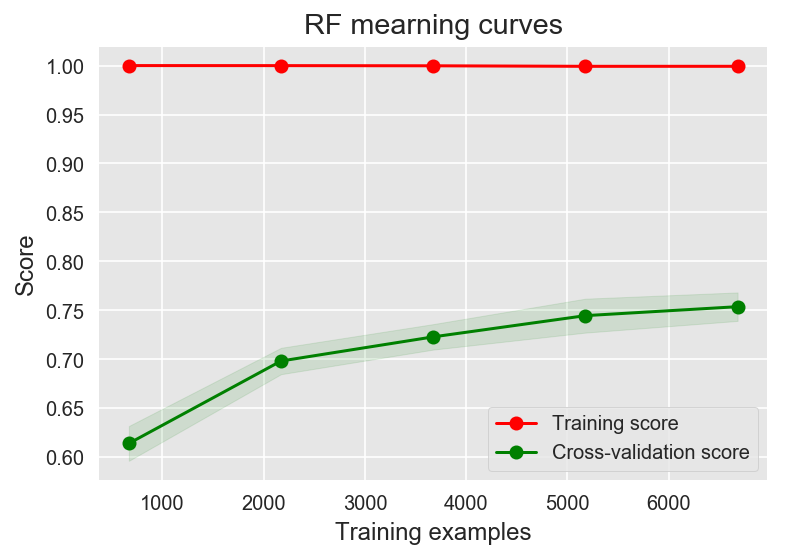

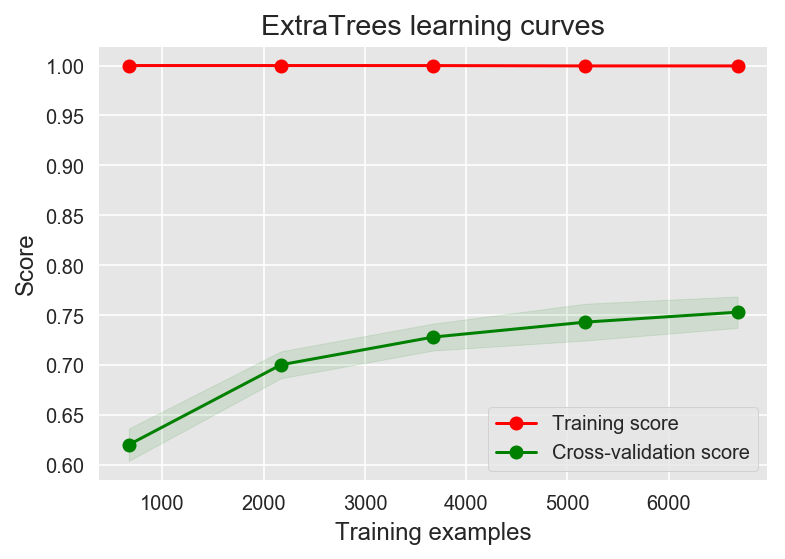

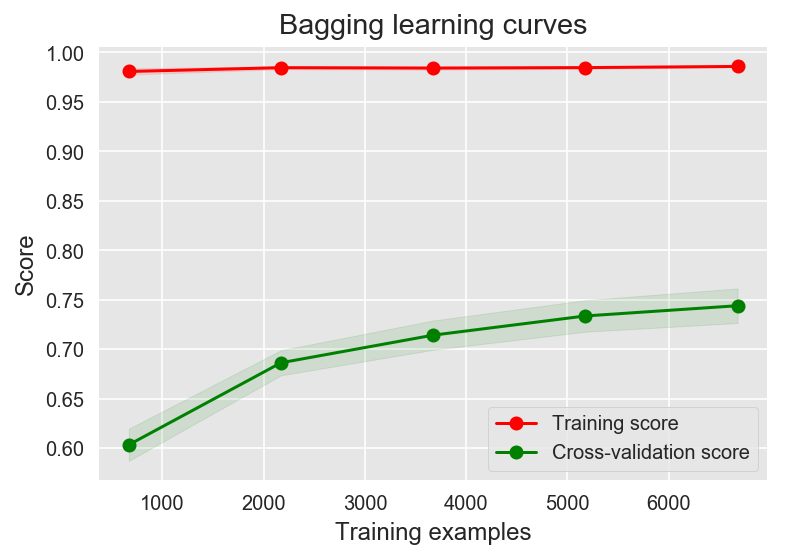

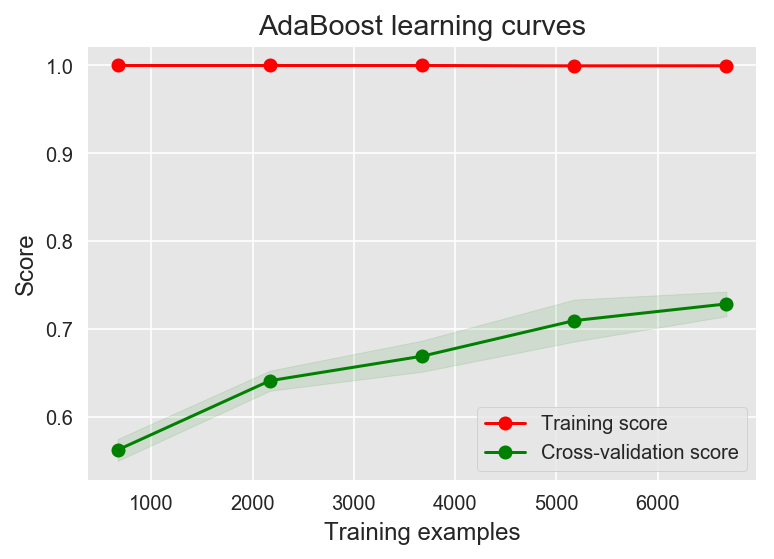

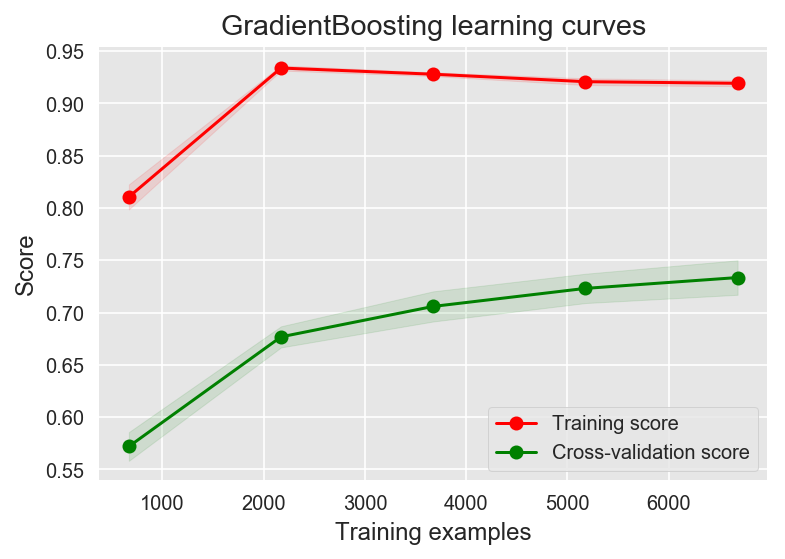

In [39]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                        cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gs_RFC.best_estimator_,"RF mearning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gs_ExtC.best_estimator_,"ExtraTrees learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gs_BC.best_estimator_,"Bagging learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gs_adaDTC.best_estimator_,"AdaBoost learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gs_GBC.best_estimator_,"GradientBoosting learning curves",X_train,y_train,cv=kfold)

### Plot Confusion Matrix
- plot the normalized and unnormalized confusion matrix

In [40]:
import itertools
from sklearn.metrics import confusion_matrix, recall_score, classification_report

Recall metric in the testing dataset:  0.9108910891089109
Confusion matrix, without normalization
[[988  91   8   7   1]
 [ 72 736  75  51  13]
 [  9 111 354 148  15]
 [  4  29  67 462  71]
 [ 22  10   8 111 195]]
Normalized confusion matrix
[[0.9  0.08 0.01 0.01 0.  ]
 [0.08 0.78 0.08 0.05 0.01]
 [0.01 0.17 0.56 0.23 0.02]
 [0.01 0.05 0.11 0.73 0.11]
 [0.06 0.03 0.02 0.32 0.56]]


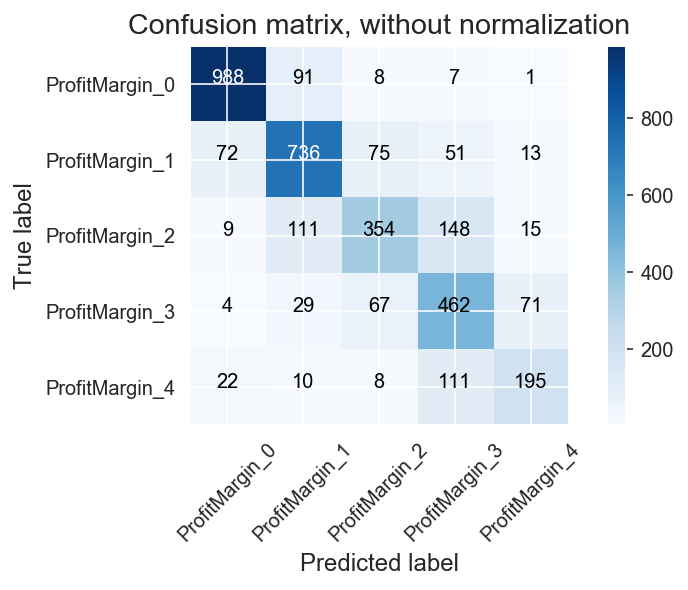

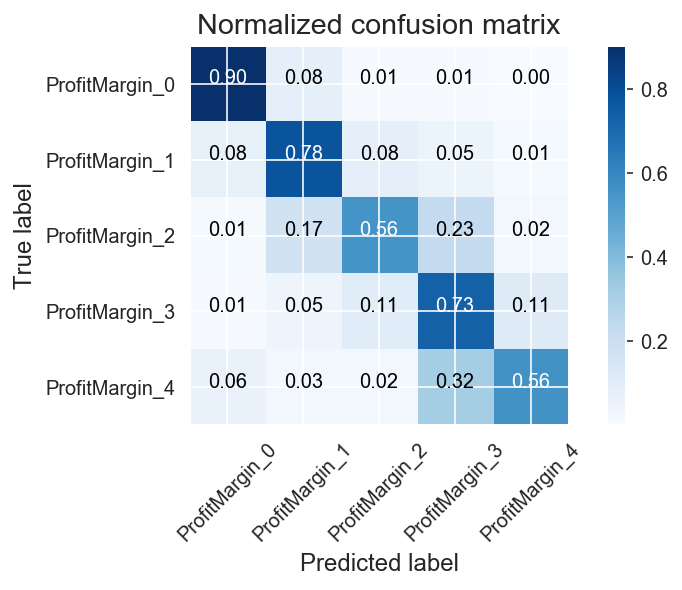

In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, pred)
np.set_printoptions(precision=2)

print('Recall metric in the testing dataset: ', cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
class_names = ['ProfitMargin_0', 'ProfitMargin_1','ProfitMargin_2','ProfitMargin_3','ProfitMargin_4']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, 
                      title='Normalized confusion matrix')

### Graph ML version of DecisionTree

In [42]:
import graphviz 

In [44]:
DTC.fit(X_train, y_train)

dot_data = tree.export_graphviz(DTC, out_file=None, 
                                feature_names = filter_feature, class_names = True,
                                filled = True, rounded = True)
graph = graphviz.Source(dot_data) 

### Feature importance of tree based classifiers
- In order to see the most informative features for the prediction of passengers survival, i displayed the feature importance for the 4 tree based classifiers.

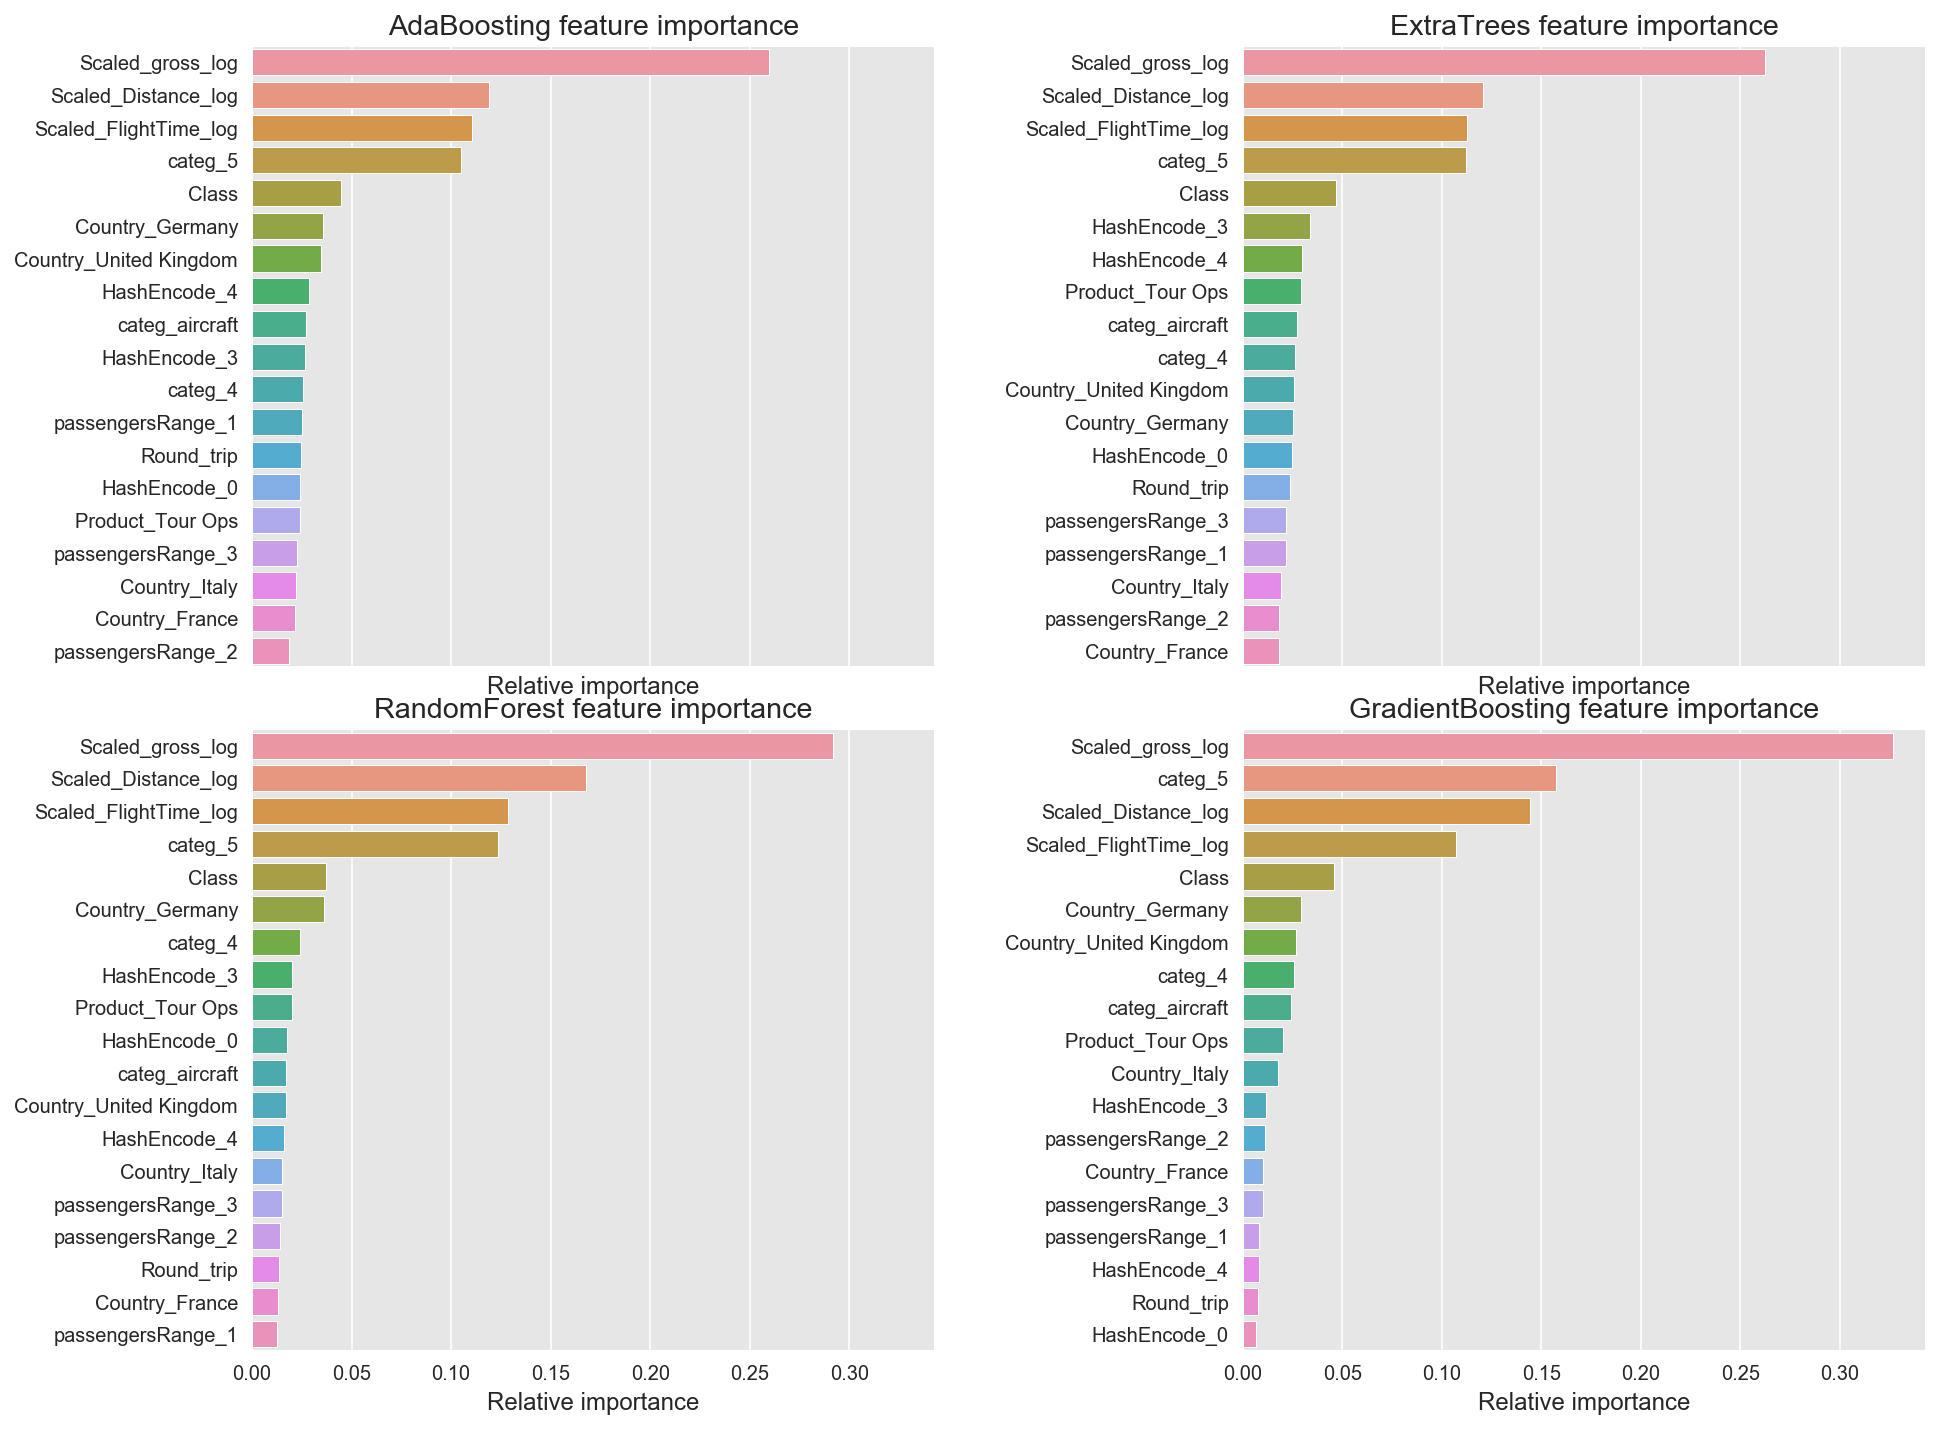

In [89]:
nrows = ncols = 2
fig.tight_layout()
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,12))
plt.subplots_adjust(wspace =0.45, hspace =0.1)

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):

        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_title(name + " feature importance")
        nclassifier += 1        

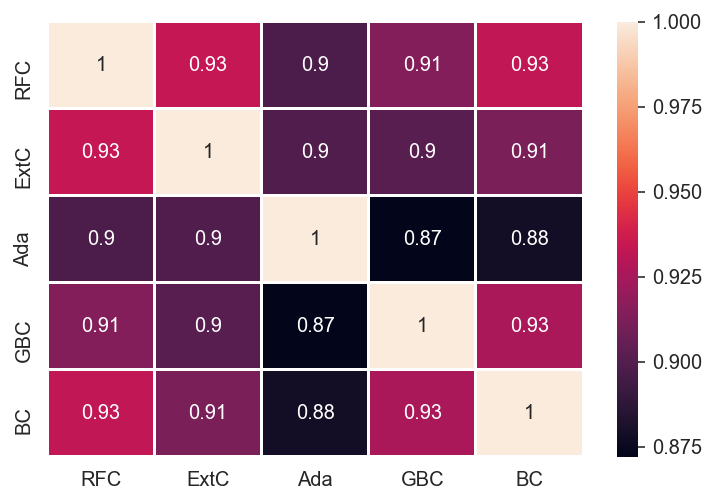

In [90]:
test_Survived_RFC = pd.Series(RFC_best.predict(X_test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(X_test), name="ExtC")
test_Survived_DTC = pd.Series(BC_best.predict(X_test), name="BC")
test_Survived_AdaC = pd.Series(ada_best.predict(X_test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(X_test), name="GBC")

# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_DTC],axis=1)

g= sns.heatmap(ensemble_results.corr(),annot=True,linewidth=1)

## Ensemble modeing
- I choose a voting classifier to combine the predicitions coming from the 5 classifiers.
- I preferred to pass the argument 'soft' to the voting parameter to take into account the probability of each vote

In [91]:
from sklearn.ensemble import VotingClassifier
from plot_metric.functions import BinaryClassification
from sklearn.preprocessing import LabelBinarizer 

In [92]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),\
('bc', BC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC.fit(X_train, y_train)
y_pred = votingC.predict(X_test)

In [93]:
pred = votingC.predict_proba(X_test)[:,1]

In [94]:
target_names = ['ProfitMargin 0', 'ProfitMargin 1', 'ProfitMargin 2', 'ProfitMargin 3', 'ProfitMargin 4']
print(classification_report(y_test, y_pred, target_names=target_names))

                precision    recall  f1-score   support

ProfitMargin 0       0.90      0.91      0.90      1095
ProfitMargin 1       0.77      0.77      0.77       947
ProfitMargin 2       0.67      0.60      0.63       637
ProfitMargin 3       0.63      0.70      0.66       633
ProfitMargin 4       0.66      0.65      0.66       346

     micro avg       0.76      0.76      0.76      3658
     macro avg       0.73      0.72      0.72      3658
  weighted avg       0.76      0.76      0.76      3658



### 6.3 Prediction and Submit results